A notebook for generating averaged triggered averages of single cell DFF traces

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import glob
import itertools
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from janelia_core.dataprocessing.baseline import percentile_filter_1d
from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats
from janelia_core.stats.regression import grouped_linear_regression_acm_linear_restriction_stats
from janelia_core.stats.regression import visualize_coefficient_stats

from keller_zlatic_vnc.data_processing import calc_dff
from keller_zlatic_vnc.data_processing import count_unique_subjs_per_transition
from keller_zlatic_vnc.data_processing import find_before_and_after_events
from keller_zlatic_vnc.data_processing import generate_standard_id_for_full_annots
from keller_zlatic_vnc.data_processing import read_full_annotations
from keller_zlatic_vnc.data_processing import read_trace_data
from keller_zlatic_vnc.data_processing import single_cell_extract_dff_trace

from keller_zlatic_vnc.linear_modeling import one_hot_from_table

/Users/bishopw/Documents/Janelia_Research/Projects/janelia_core/janelia_core/fileio/exp_reader.py:21: UserWarning: Unable to locate pyklb module.  Will not be able to read in .klb files.
  warnings.warn('Unable to locate pyklb module.  Will not be able to read in .klb files.')


In [3]:
%matplotlib notebook

## Parameters go here 

In [36]:
ps = dict()

# The file specifying which subjects we should include in the analysis
ps['subject_file'] = r'/Volumes/bishoplab/projects/keller_vnc/data/single_cell/subjects.csv'

# Location of files provided by Chen containing the raw fluorescence traces for the single cells
ps['trace_base_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/single_cell/single_cell_traces'
ps['a00c_trace_folder'] = 'A00c'
ps['basin_trace_folder'] = 'Basin'
ps['handle_trace_folder'] = 'Handle'

# Location of folders containing annotations
ps['a4_annot_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/full_annotations/behavior_csv_cl_A4'
ps['a9_annot_folder'] = r'/Volumes/bishoplab/projects/keller_vnc/data/full_annotations/behavior_csv_cl_A9'

# Specify the type of neurons we analyze
ps['cell_type'] = 'a00c'

# Specfy the cell ids we analyze as a list. If None, we analyze all cell ids
ps['cell_ids']  = None

# Parameters for calculating Delta F/F

ps['baseline_calc_params'] = dict()
ps['baseline_calc_params']['window_length'] = 30001
ps['baseline_calc_params']['filter_start'] = -1500
ps['baseline_calc_params']['write_offset'] = 1500
ps['baseline_calc_params']['p'] = 0.1

ps['dff_calc_params'] = dict()
ps['dff_calc_params']['background'] = 100
ps['dff_calc_params']['ep'] = 20

# Specify which behaviors we are willing to include in the analysis - b/c we have to see each behavior in 
# enough subjects (see below) all of these behaviors may not be included in an analysis, but this gives the
# list of what we are least willing to consider.  If None, all behaviors will be considered

ps['behs'] = ['Q', 'TC', 'B', 'F', 'H']

# The particular behavior we treat as a reference
ps['ref_beh'] = 'Q'

# Specify the minimum number of subjects we have to see preceeding and succeeding behaviors in to include in the
# analysis
ps['min_n_pre_subjs'] = 3

# Specify the minimum number of subjects we have to see preceeding and succeeding behaviors in to include in the
# analysis
ps['min_n_succ_subjs'] = 3

# Specify the manipulation target for subjects we want to analyze, None indicates both A4 and A9
ps['man_tgt'] = None

# Say if we should pool preceeding and succeeding turns
ps['pool_pre_turns'] = True
ps['pool_succ_turns'] = True

# Parameters for declaring preceeding and succeeding quiet behaviors
ps['pre_q_th'] = 50
ps['succ_q_th'] = 9

# Parameters for determing the location of the marked preceeding and succeeding quiet events
ps['pre_q_offset'] = -4 # Offset in time points from start of stimulus
ps['pre_q_event_l'] = 3 # Event length for the preceeding quiet event
ps['succ_q_event_l'] = 3 # Event length for the succeeding quiet event

# The type of window we use
ps['dff_window_type'] = 'start_aligned'
# The reference we use for aligning windows
ps['dff_window_ref'] = 'beh_before_start'

# The offset we applying when placing DFF windows
ps['dff_window_offset'] = 0

# The length of the window we calculate DFF in
ps['dff_window_length'] = 3 #3

# The event we align the end of the window to (if we are not using windows of fixed length)
ps['dff_window_end_ref'] = 'end'

# The offset when aligning the end of the window (if we are not using windows of fixed length)
ps['dff_window_end_offset'] = 1 


## Read in the basic data for each subject.

In [5]:
# Get the list of all subjects we need to process
subjects = list(pd.read_csv(ps['subject_file'])['Subject'])

In [6]:
data = read_trace_data(subjects=subjects, 
                   a00c_trace_folder=Path(ps['trace_base_folder'])/ps['a00c_trace_folder'], 
                   handle_trace_folder=Path(ps['trace_base_folder'])/ps['handle_trace_folder'], 
                   basin_trace_folder=Path(ps['trace_base_folder'])/ps['basin_trace_folder'])

No traces found for handle cells for subject CW_17-08-23-L1.
Done reading in data for subject 1 of 64.
Done reading in data for subject 2 of 64.
Done reading in data for subject 3 of 64.
Done reading in data for subject 4 of 64.
Done reading in data for subject 5 of 64.
Done reading in data for subject 6 of 64.
Done reading in data for subject 7 of 64.
Done reading in data for subject 8 of 64.
Done reading in data for subject 9 of 64.
Done reading in data for subject 10 of 64.
Done reading in data for subject 11 of 64.
Done reading in data for subject 12 of 64.
Done reading in data for subject 13 of 64.
Done reading in data for subject 14 of 64.
Done reading in data for subject 15 of 64.
No traces found for handle cells for subject CW_17-08-27-L3.
Done reading in data for subject 16 of 64.
Done reading in data for subject 17 of 64.
Done reading in data for subject 18 of 64.
Done reading in data for subject 19 of 64.
Done reading in data for subject 20 of 64.
Done reading in data for su

## Calculate $\Delta F/F$ for each cell

In [7]:
n_cells = data.shape[0]
dff = [None]*n_cells
for cell_row, cell_idx in enumerate(data.index):
    baseline = percentile_filter_1d(data['f'][cell_idx], **ps['baseline_calc_params']) 
    dff[cell_row] = calc_dff(f=data['f'][cell_idx], b=baseline, **ps['dff_calc_params'])

data['dff'] = dff

In [8]:
# Creata a full_data table, so we can re-run the code below multiple times without having to calculate DFF again
full_data = data

## Down select to only the cells of the type and id we want to analyze

In [62]:
data = copy.deepcopy(full_data)

In [63]:
# Down select by cell type
data = data[data['cell_type'] == ps['cell_type']]

# Down select by cell id
if ps['cell_ids'] is not None:
    data = data[data['cell_id'].isin(ps['cell_ids'])]

## Find stimulus events for the subjects we are analyzing

In [64]:
# Get list of subjects we have annotations for
a4_file_paths = glob.glob(str(Path(ps['a4_annot_folder']) / '*.csv'))
a9_file_paths = glob.glob(str(Path(ps['a9_annot_folder']) / '*.csv'))

n_annot_files = len(a4_file_paths) + len(a9_file_paths)
a4_files = np.zeros(n_annot_files, dtype=np.bool)
a4_files[0:len(a4_file_paths)] = True

annot_file_paths = a4_file_paths + a9_file_paths

annot_file_names = [Path(p).name for p in annot_file_paths]
annot_subjs = [generate_standard_id_for_full_annots(fn) for fn in annot_file_names]

In [65]:
# Get stimulus events for each subject we analyze
analysis_subjs = list(data['subject_id'].unique())
subj_events = pd.DataFrame()

for subj in analysis_subjs:
    
    # Find the annotations for this subject
    ind = np.argwhere(np.asarray(annot_subjs) == subj)
    if len(ind) == 0:
        raise(RuntimeError('Unable to find annotations for subject ' + subj + '.'))
    else:
        ind = ind[0][0]
        
    # Load the annotations for this subject
    tbl = read_full_annotations(annot_file_paths[ind])
    
    # Pull out stimulus events for this subject, noting what comes before and after
    stim_tbl = copy.deepcopy(tbl[tbl['beh'] == 'S'])
    stim_tbl.insert(0, 'subject_id', subj)
    stim_tbl.insert(1, 'event_id', range(stim_tbl.shape[0]))
    if a4_files[ind] == True:
        stim_tbl.insert(2, 'manipulation_tgt', 'A4')
    else:
        stim_tbl.insert(2, 'manipulation_tgt', 'A9')
    before_after_tbl = find_before_and_after_events(events=stim_tbl, all_events=tbl)
    stim_annots = pd.concat([stim_tbl, before_after_tbl], axis=1)
    subj_events = subj_events.append(stim_annots, ignore_index=True)


## Get rid of any events where we could not classify the type of preceeding or succeeding behavior 

In [66]:
subj_events = subj_events.dropna()

## Mark preceeding and succeeding quiet events

In [67]:
delta_before = subj_events['start'] - subj_events['beh_before_end']
delta_after = subj_events['beh_after_start'] - subj_events['end']

before_quiet_inds = delta_before > ps['pre_q_th']
after_quiet_inds = delta_after > ps['succ_q_th']


subj_events.loc[before_quiet_inds, 'beh_before'] = 'Q'
subj_events.loc[after_quiet_inds, 'beh_after'] = 'Q'

Mark the start and stop of the marked quiet events

In [96]:
if -ps['pre_q_offset'] >= (ps['pre_q_th'] + 1): # +1 because of > in applying threshold 
    raise(RuntimeError('-pre_q_offset must be one less than pre_q_th + 1'))
if -ps['pre_q_offset'] < ps['pre_q_event_l']:
    raise(RuntimeError('-pre_q_offset must be greater than or equal to pre_q_event_l'))

In [97]:
if ps['succ_q_event_l'] > np.ceil(ps['succ_q_th']/2):
    raise(RuntimeError('succ_q_event_l must be greater than floor(succ_q_th)/2)'))

In [68]:
new_before_start = subj_events[before_quiet_inds]['start'] + ps['pre_q_offset'] 
new_before_end = new_before_start + ps['pre_q_event_l'] - 1 # Minus 1 for inclusive indexing 
subj_events.loc[before_quiet_inds, 'beh_before_start'] = new_before_start
subj_events.loc[before_quiet_inds, 'beh_before_end'] = new_before_end

In [69]:
new_after_start = (np.ceil((subj_events[after_quiet_inds]['beh_after_start'] - 
                               subj_events[after_quiet_inds]['end'])/2) + 
                   subj_events[after_quiet_inds]['end'])
new_after_end = new_after_start + ps['succ_q_event_l'] - 1 # Minus 1 for inclusive indexing 

subj_events.loc[after_quiet_inds, 'beh_after_start'] = new_after_start
subj_events.loc[after_quiet_inds, 'beh_after_end'] = new_after_end

## Down select events based on manipulation target

In [71]:
if ps['man_tgt'] is not None:
    subj_events = subj_events[subj_events['manipulation_tgt'] == ps['man_tgt']]

## Pool turns if we are suppose to 

In [72]:
if ps['pool_pre_turns']:
    turn_rows = (subj_events['beh_before'] == 'TL') | (subj_events['beh_before'] == 'TR')
    subj_events.loc[turn_rows, 'beh_before'] = 'TC'

if ps['pool_succ_turns']:
    turn_rows = (subj_events['beh_after'] == 'TL') | (subj_events['beh_after'] == 'TR')
    subj_events.loc[turn_rows, 'beh_after'] = 'TC'

# Down select to only the type of behaviors we are willing to consider 

In [73]:
if ps['behs'] is not None:
    keep_inds = [i for i in subj_events.index if subj_events['beh_before'][i] in set(ps['behs'])]
    subj_events = subj_events.loc[keep_inds]
    
    keep_inds = [i for i in subj_events.index if subj_events['beh_after'][i] in set(ps['behs'])]
    subj_events = subj_events.loc[keep_inds]

## Drop any behaviors that do not appear in enough subjects

In [74]:
subj_trans_counts = count_unique_subjs_per_transition(table=subj_events)
n_before_subjs = subj_trans_counts.sum(axis=1)
n_after_subjs = subj_trans_counts.sum(axis=0)

before_an_behs = set([i for i in n_before_subjs.index if n_before_subjs[i] >= ps['min_n_pre_subjs']])
after_an_behs = set([i for i in n_after_subjs.index if n_after_subjs[i] >= ps['min_n_succ_subjs']])

keep_inds = [i for i in subj_events.index if subj_events['beh_before'][i] in before_an_behs]
subj_events = subj_events.loc[keep_inds]

keep_inds = [i for i in subj_events.index if subj_events['beh_after'][i] in after_an_behs]
subj_events = subj_events.loc[keep_inds]

## Calcualte event triggered averages here 

In [80]:
ref_offset = -10
window_l = 21

In [81]:
beh_before_extracted_traces = single_cell_extract_dff_trace(activity_tbl=data, event_tbl=subj_events, 
                                                 align_col='beh_before_start',
                                                 ref_offset=ref_offset, window_l=window_l)

<IPython.core.display.Javascript object>


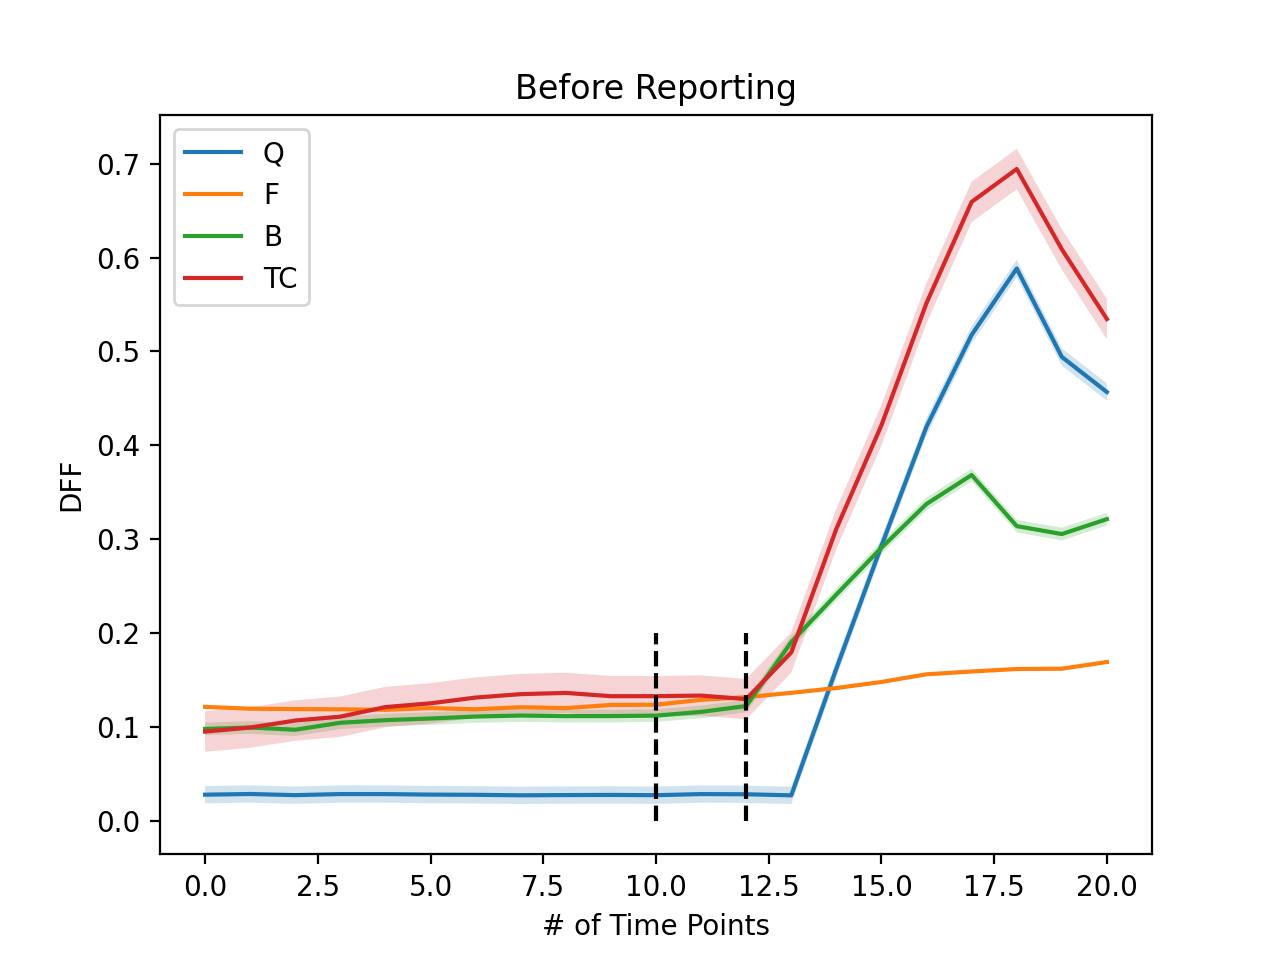

Text(0.5, 1.0, 'Before Reporting')

In [82]:
plt_behs = ['Q', 'F', 'B', 'TC']
plt.figure()
ax = plt.subplot(1,1,1)
for beh in plt_behs:
    beh_dff = beh_before_extracted_traces[beh_before_extracted_traces['beh_before'] == beh]['dff'].to_numpy()
    beh_mn = np.mean(beh_dff, axis=0)
    beh_std_er = np.std(beh_mn, axis=0)/np.sqrt(beh_dff.shape[0])
    
    ax.fill_between(np.arange(len(beh_mn)), beh_mn-beh_std_er, beh_mn+beh_std_er, alpha=.2)
    ax.plot(beh_mn)
    
ax.plot([-1*ref_offset, -1*ref_offset], [0, .2], 'k--')
ax.plot([-1*ref_offset+2, -1*ref_offset+2], [0, .2], 'k--')
    
plt.legend(plt_behs)
plt.xlabel('# of Time Points')
plt.ylabel('DFF')
plt.title('Before Reporting')
    

In [83]:
beh_after_extracted_traces = single_cell_extract_dff_trace(activity_tbl=data, event_tbl=subj_events, 
                                                 align_col='beh_after_start',
                                                 ref_offset=ref_offset, window_l=window_l)

<IPython.core.display.Javascript object>


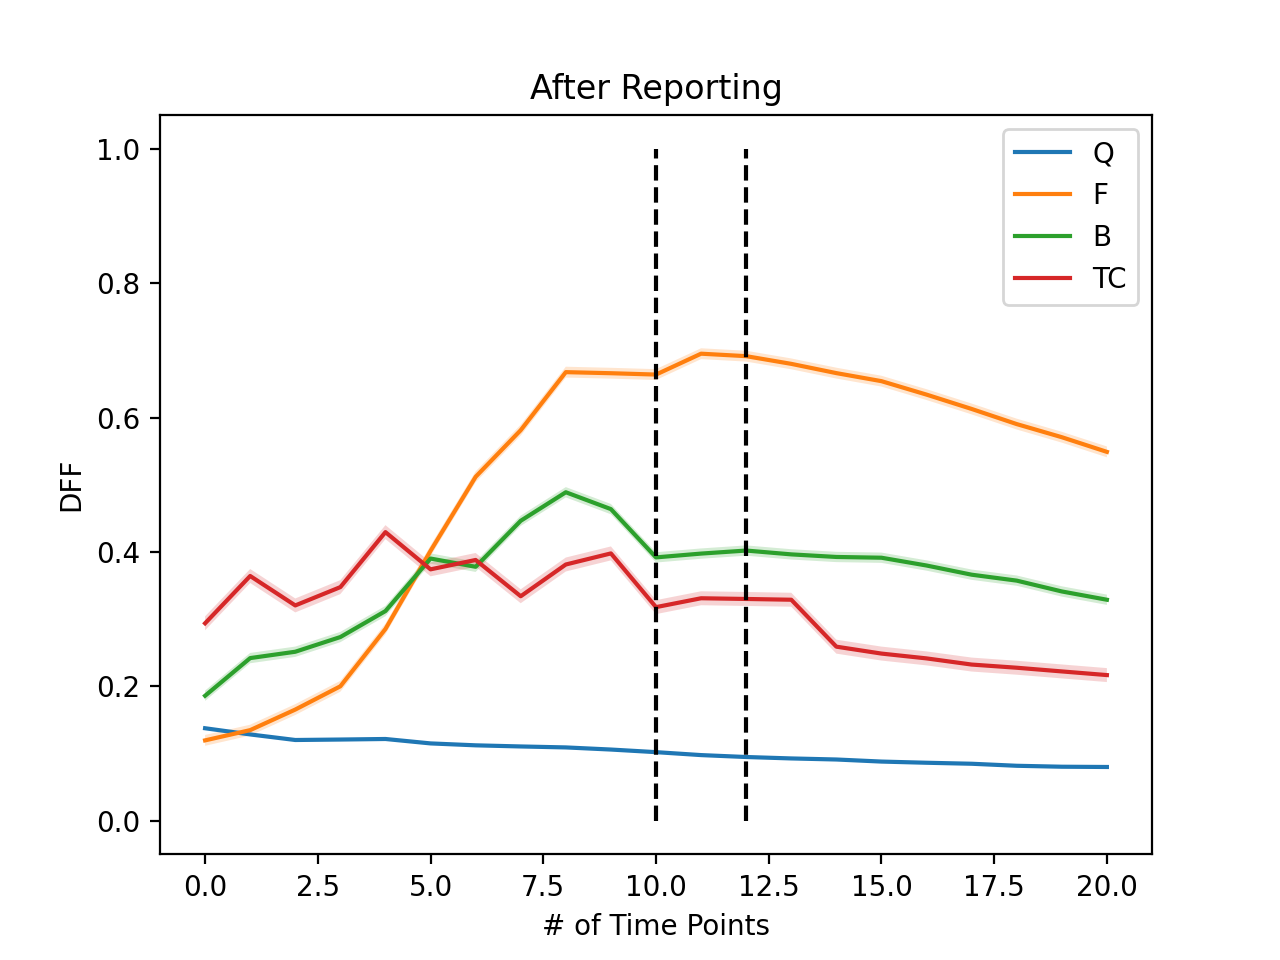

Text(0.5, 1.0, 'After Reporting')

In [84]:
plt.figure()
ax = plt.subplot(1,1,1)
for beh in plt_behs:
    beh_dff = beh_after_extracted_traces[beh_after_extracted_traces['beh_after'] == beh]['dff'].to_numpy()
    beh_mn = np.mean(beh_dff, axis=0)
    beh_std_er = np.std(beh_mn, axis=0)/np.sqrt(beh_dff.shape[0])
    
    ax.fill_between(np.arange(len(beh_mn)), beh_mn-beh_std_er, beh_mn+beh_std_er, alpha=.2)
    ax.plot(beh_mn)
    
ax.plot([-1*ref_offset, -1*ref_offset], [0, 1], 'k--')
ax.plot([-1*ref_offset+2, -1*ref_offset+2], [0, 1], 'k--')
    
plt.legend(plt_behs)
plt.xlabel('# of Time Points')
plt.ylabel('DFF')
plt.title('After Reporting')